# A very simple multi-agent example

One of the difficulties of working out how to employ AI agents is understanding complex workflows and interactions. Here is a very simple set-up to demonstrate agents at work.

## The scenario: A team to create a word - literally just a string "cat"

Build a team of 3 very simple agents:
1. **Coordinator:** stores the overall state of the task, and interacts with the 2 worker agents (below). Knows that it needs to build a string of 3 characters representing the word "cat".
    - **NOTE:** Later on in this notebook, we'll change the **Coordinator** for an **Instructor**.
2. **LetterBot:** Takes a number as an input, and returns the letter within the word "cat" corresponding to that number. E.g. `input: 3, output: "t"`
3. **CheckerBot:** Takes two inputs, a number and a letter, and returns `"Yes"` if the number is the index for that given letter in the word "cat" (indexed from 1). Otherwise it returns `"No"`.

## Step 1: Build it all in code, instead of using AI Agents

Here, we demonstrate the workflow, with as little code as possible. Note that Python indexes from zero so we have to adjust index values so that we start indexing at 1.

In [1]:
word = "cat"

def LetterFunc(number):
    return word[number - 1]

def CheckerFunc(number, letter):
    if word[number - 1] == letter:
        return "Yes"
    return "No"

def CoordinatorFunc():
    result = ""
    for number in range(1, len(word) + 1):
        print(f"Requesting letter for: {number}")
        letter = LetterFunc(number)
        print(f"Checking correctness for: {number}, '{letter}'")
        assert CheckerFunc(number, letter) == "Yes"
        print(f"Appending to result: '{letter}'")
        result += letter

    print(f"Task completed! Result: '{result}'")    

Let's run it and see the result...

In [2]:
CoordinatorFunc()

Requesting letter for: 1
Checking correctness for: 1, 'c'
Appending to result: 'c'
Requesting letter for: 2
Checking correctness for: 2, 'a'
Appending to result: 'a'
Requesting letter for: 3
Checking correctness for: 3, 't'
Appending to result: 't'
Task completed! Result: 'cat'


## Step 2: Build it all in with AI Agents, and let them do the work

Having established what the workflow should look like, let's create a simple version that uses Agents. We'll prompt the agents with as little information as required to get the job done. We will need to create 3 Agents, in this case as OpenAI _Assistants_, using the base LLM `gpt-4o-mini`.

### Set-up

Import relevant libraries and set up `OPENAI_API_KEY` environment variable which authenticates to the OpenAI APIs.

In [3]:
import os, time, json
from IPython import display
from openai import OpenAI

keyfile = os.path.expanduser(f"~/.openai-skills-evalution-api-key")
os.environ["OPENAI_API_KEY"] = open(keyfile).read().strip()

def show_json(obj):
    display(json.loads(obj.model_dump_json()))

client = OpenAI()

### Create the Agents

In [4]:
# We'll store the IDs in here to avoid creating lots of duplicate agents
agent_ids = {
    "CoordinatorBot": "asst_hQlldJuYdkJyP8AQe5PGUnJc",
    "LetterBot": "asst_8jUY5XgjmNrFpHZdLOCAr2cD",
    "CheckerBot": "asst_CygKcftXIFnYNtjea1vu4jMA"
}

agent_prompts = {
    "CoordinatorBot": """
You are an agent who has a specific responsibility to build a string of 3 characters that represent the word "cat".
You can ONLY DO THIS BY TALKING TO OTHER AGENTS. Whenever you get an instruction to REPORT, then write a message to the thread so that the user can get an update on progress.

The two OpenAI assistants that you can interact with are:
 - "LetterBot" (ID: asst_8jUY5XgjmNrFpHZdLOCAr2cD)
 - "CheckerBot" (ID: asst_CygKcftXIFnYNtjea1vu4jMA)

You will start by storing an empty string. Then you will repeat the following task 3 times, once for each character in the word "cat":
  1. Take a number $N. It will be 1 for the first iteration, 2 for the second iteration, all the way up to 3 for the final iteration.
  2. REPORT: "Sending number $N to LetterBot"
  3. Contact the assistant called `LetterBot`, and send it only the number $N. DO NOT SEND IT ANY OTHER TEXT OR CONTENT!
  4. `LetterBot` will return a single letter, $L, in its response.
  5. REPORT: "LetterBot returned: $L"
  6. If `LetterBot` responds with anything not in "cat", then return: "SORRY, WE FAILED!", followed by the number $N. STOP WORK IF THIS HAPPENS!
  7. REPORT: "Sending $N, $L to CheckerBot"  
  8. Then contact the assistant called `CheckerBot`, and send it only a $N and $L that was returned by `LetterBot`. FOLLOW THIS INSTRUCTION EXACTLY.
  9. REPORT: "CheckerBot returned: ${response from LetterBot}"
  10. If `CheckerBot` responds with "No", then stop the process and respond with "SORRY, WE FAILED!", followed by the number $N and the single letter returned by `LetterBot`. STOP WORK IF THIS HAPPENS!
  11. `CheckerBot` must only return "No" or "Yes", so we assume it has returned "Yes" if we get here. 
  12. REPORT: "Added $L to my result"
  13. Append the letter returned by `LetterBot` to your current string of characters.
  14. If less than 3 characters have been added to the string, start the next iteration of the loop.
  15. If all 3 characters have been added to the string, REPORT: "My work is done! Result: ${the complete string}."
""",

    "LetterBot": """
You are an agent who ONLY KNOWS ABOUT THE LETTERS IN THE WORD "cat" AND THE CORRESPONDING 3 NUMBERS THAT INDEX THEM.
Your job is to translate a number (index) into a lower-case letter from the word "cat".
When you receive a message, do the following:
1. If it is not a number between 1 and 3: RETURN THE STRING: "Not found!"
2. If it is a number between 1 and 3: RETURN THE LETTER CORRESPONDING TO THAT NUMBER WHEN INDEXED FROM 1
NOTE: If you need help with counting in order to work out the index, you can use this Python code:
`letter = "cat"[number - 1]` 
""",

    "CheckerBot":  """
You are an agent who ONLY KNOWS ABOUT THE LETTERS IN THE WORD "cat" AND THE CORRESPONDING 3 NUMBERS THAT INDEX THEM.
Your job is to check that a number (index) corresponds to a letter in the word "cat".
IT IS IMPORTANT TO KNOW THAT THE INDEXING STARTS AT 1 (NOT 0)!
When you receive a message, do the following:
1. Remove any punctuation from the input text you recieve.
2. If you have not received a number (between 1 and 3) and a letter (from "cat"), then RETURN THE STRING: "BAD INPUT!"
3. Otherwise, check that the number is the correct index value to find the letter in the word "cat" (when indexing from 1).
4. If correct: RETURN: "Yes".
5. If incorrect: RETURN: "No".
NOTE: If you need help calculating whether the index and letter correspond, you can use the Python code:
`result = "Yes" if "cat"[number - 1] == letter else "No"`
"""
}

#### NOTE: Assistants are persitent so test for their IDs and update the agent_data dict accordingly


This stops us creating lots of identical OpenAI Assistants!

In [5]:
def get_assistant_ids():
    my_assistants = client.beta.assistants.list(
        order="desc",
        limit="50",
    )
    ids = [asst.id for asst in my_assistants.data]
    return ids

In [6]:
def create_agents(agent_prompts=agent_prompts):
    # Get current IDs
    existing_assistant_ids = get_assistant_ids()
    
    for agent_name, prompt in agent_prompts.items():
        assistant_id = agent_ids.get(agent_name, "")
    
        if not assistant_id or assistant_id not in existing_assistant_ids:
            print(f"Creating agent: {agent_name}")
            assistant = client.beta.assistants.create(
                name=agent_name,
                instructions=prompt.strip(),
                model="gpt-4o-mini")

            print(assistant)
            agent_ids[agent_name] = assistant.id
        else:
            print(f"Agent '{agent_name}' already exists")

In [7]:
create_agents()

Agent 'CoordinatorBot' already exists
Agent 'LetterBot' already exists
Agent 'CheckerBot' already exists


### Now we have a set of agents ready to do their work

In [8]:
agent_ids

{'CoordinatorBot': 'asst_hQlldJuYdkJyP8AQe5PGUnJc',
 'LetterBot': 'asst_8jUY5XgjmNrFpHZdLOCAr2cD',
 'CheckerBot': 'asst_CygKcftXIFnYNtjea1vu4jMA'}

## Getting agents to talk to each other

From the investigations I have done so far, you cannot just tell an OpenAI Assistant to *talk to* another OpenAI Assistant. You need to **write some code to glue them together**. 

### Attempt 1: My code acts as the CoordinatorBot

In this first example, I just want to alternate between talking to the `LetterBot` and the `CheckerBot`. In this case, the `run()` method plays the part of the `CoordinatorBot` so the code only corresponds with a single agent at a time.

In [145]:
class ProjectWithoutCoordinator:
    
    def __init__(self, assistants, DEBUG=False):
        self.assistants = assistants
        self.DEBUG = DEBUG

    def run(self):
        self.thread = client.beta.threads.create()
        print(f"Working on thread: {self.thread.id}")
        result = ""

        for number in [1, 2, 3]:
            letter = self.send_message("LetterBot", f"{number}")
            check = self.send_message("CheckerBot", f"{number} {letter}")
            if check != "Yes":
                raise Exception(f"FAILED: CheckerBot responded with '{check}' to inputs: {number} {letter}")

            result = result + letter

        assert result == "cat"
        print(f"It worked! Got result: {result}")

    def wait_on_run(self, run):
        while run.status == "queued" or run.status == "in_progress":
            run = client.beta.threads.runs.retrieve(thread_id=self.thread.id, run_id=run.id)
            if self.DEBUG: print(f"Polling for run: {run.id}")
            time.sleep(1)
        return run
            
    def log(self, assistant, message):
        print(f"[INFO] Response from {assistant}: {message}")

    def get_response(self):
        return client.beta.threads.messages.list(thread_id=self.thread.id, order="desc")
    
    def send_message(self, assistant, message):
        client.beta.threads.messages.create(
            thread_id=self.thread.id, role="user", content=message
        )

        run = client.beta.threads.runs.create(
            thread_id=self.thread.id, assistant_id=self.assistants[assistant]
        )
        run = self.wait_on_run(run)

        response = self.get_response()
        message_content = response.data[0].content[0].text.value
        
        self.log(assistant, message_content)
        return message_content


pwc = ProjectWithoutCoordinator(agent_ids)
pwc.run()

Working on thread: thread_BZEFBN0S70sif9t378uVlgrV
[INFO] Response from LetterBot: c
[INFO] Response from CheckerBot: Yes
[INFO] Response from LetterBot: a
[INFO] Response from CheckerBot: Yes
[INFO] Response from LetterBot: t
[INFO] Response from CheckerBot: Yes
It worked! Got result: cat


### Attempt 2: include CoordinatorBot - which runs the show

In this example, I want to hand off all management of the flow to `CoordinatorBot`. However, I think that the I need to modify the definition of the agent in order to do this.

The existing `CoordinatorBot` is told to talk directly to other agents. However, I don't know if this is possible in the OpenAI API. The **alternative is to tell it to respond with instructions for the code running it**, such as:
- `MESSAGE FOR CheckerBot: 1 c`
- `MESSAGE FOR LetterBot:  2`

So, I need to create a new version that I'll call `InstructorBot`:

In [138]:
agent_prompts["InstructorBot"] = """
You are an agent who has a specific responsibility to build a string of 3 characters that represent the word "cat".
You can ONLY DO THIS BY CREATING INSTRUCTIONS FOR OTHER AGENTS. 
Whenever you get an instruction to REPORT, then write a message to the thread so that the user can get an update on progress.
All your INSTRUCTIONS FOR OTHER AGENTS SHOULD BE IN THE FORM:
"MESSAGE FOR ${agent_name}: ${message}"

Your response will be parsed by code in the client, which will then send that message to the Agent specified.

IMPORTANT: The next message you receive will be forwarded from the Agent that you gave the instruction to.

The two OpenAI assistants that you can interact with are:
 - "LetterBot" (ID: asst_8jUY5XgjmNrFpHZdLOCAr2cD)
 - "CheckerBot" (ID: asst_CygKcftXIFnYNtjea1vu4jMA)

You will start by storing an empty string. Then you will repeat the following task 3 times, once for each character in the word "cat":
  1. Take a number $N. It will be 1 for the first iteration, 2 for the second iteration, all the way up to 3 for the final iteration.
  2. REPORT: "Sending number $N to LetterBot"
  3. Write an instruction for the assistant called `LetterBot`, containing only the number $N. DO NOT SEND IT ANY OTHER TEXT OR CONTENT!
  4. `LetterBot` will return a single letter, $L, in its response.
  5. REPORT: "LetterBot returned: $L"
  6. If `LetterBot` responds with anything not in "cat", then return: "SORRY, WE FAILED!", followed by the number $N. STOP WORK IF THIS HAPPENS!
  7. REPORT: "Sending $N, $L to CheckerBot"
  8. Write an instruction for the assistant called `CheckerBot`, containing only $N and $L that was returned by `LetterBot`. FOLLOW THIS INSTRUCTION EXACTLY.
  9. REPORT: "CheckerBot returned: ${response from LetterBot}"
  10. If `CheckerBot` responds with "No", then stop the process and respond with "SORRY, WE FAILED!", followed by the number $N and the single letter returned by `LetterBot`. STOP WORK IF THIS HAPPENS!
  11. `CheckerBot` must only return "No" or "Yes", so we assume it has returned "Yes" if we get here. 
  12. REPORT: "Added $L to my result"
  13. Append the letter returned by `LetterBot` to your current string of characters.
  14. If less than 3 characters have been added to the string, start the next iteration of the loop.
  15. If all 3 characters have been added to the string, REPORT: "My work is done! Result: ${the complete string}."
"""

In [140]:
create_agents()

Agent 'CoordinatorBot' already exists
Agent 'LetterBot' already exists
Agent 'CheckerBot' already exists
Agent 'InstructorBot' already exists


In [141]:
agent_ids["InstructorBot"] = "asst_bbC6ZuAoxuVI1vx9kOhvJVwP"

### So, let's create the new class



In [146]:
class ProjectWithInstructor:
    
    def __init__(self, assistants, DEBUG=False):
        self.assistants = assistants
        self.DEBUG = DEBUG
        self.routes = {f"MESSAGE FOR {agent}": agent for agent in ("LetterBot", "CheckerBot")}

    def run(self):
        self.thread = client.beta.threads.create()
        print(f"Working on thread: {self.thread.id}")
        result = ""

        msg = self.send_message("InstructorBot", "Do a run")

        while "My work is done" not in msg and "WE FAILED" not in msg:
            resp = self.reroute_msg_to_agent(msg)
            msg = resp
        
        print(f"Finished! Message: {msg}")

    def reroute_msg_to_agent(self, msg):
        for route in self.routes:
            if route in msg:
                return self.send_message(self.routes[route], msg.split(":")[-1].strip())
        # Else, return to InstructorBot
        return self.send_message("InstructorBot", msg)

    # Waiting in a loop
    def wait_on_run(self, run):
        while run.status == "queued" or run.status == "in_progress":
            run = client.beta.threads.runs.retrieve(thread_id=self.thread.id, run_id=run.id)
            if self.DEBUG: print(f"Polling for run: {run.id}")
            time.sleep(1)
        return run
            
    def log(self, assistant, message):
        print(f"[INFO] Response from {assistant}: {message}")

    def get_response(self):
        return client.beta.threads.messages.list(thread_id=self.thread.id, order="desc")
    
    def send_message(self, assistant, message):
        client.beta.threads.messages.create(
            thread_id=self.thread.id, role="user", content=message
        )

        print(f"Sending to '{assistant}': {message}")
        run = client.beta.threads.runs.create(
            thread_id=self.thread.id, assistant_id=self.assistants[assistant]
        )
        run = self.wait_on_run(run)

        response = self.get_response()
        message_content = response.data[0].content[0].text.value
        
        self.log(assistant, message_content)
        return message_content


pwi = ProjectWithInstructor(agent_ids)
pwi.run()

Working on thread: thread_tnRZpWimsjUsL4C2NQ2rERwj
Sending to 'InstructorBot': Do a run
[INFO] Response from InstructorBot: MESSAGE FOR LetterBot: 1
Sending to 'LetterBot': 1
[INFO] Response from LetterBot: c
Sending to 'InstructorBot': c
[INFO] Response from InstructorBot: REPORT: "LetterBot returned: c"
MESSAGE FOR CheckerBot: 1 c
Sending to 'CheckerBot': 1 c
[INFO] Response from CheckerBot: Yes
Sending to 'InstructorBot': Yes
[INFO] Response from InstructorBot: REPORT: "Added c to my result"
MESSAGE FOR LetterBot: 2
Sending to 'LetterBot': 2
[INFO] Response from LetterBot: a
Sending to 'InstructorBot': a
[INFO] Response from InstructorBot: REPORT: "LetterBot returned: a"
MESSAGE FOR CheckerBot: 2 a
Sending to 'CheckerBot': 2 a
[INFO] Response from CheckerBot: Yes
Sending to 'InstructorBot': Yes
[INFO] Response from InstructorBot: REPORT: "Added a to my result"
MESSAGE FOR LetterBot: 3
Sending to 'LetterBot': 3
[INFO] Response from LetterBot: t
Sending to 'InstructorBot': t
[INFO] Re

**It works!**

### Afterthoughts

1. The general framework/pattern of the code could be tidied and re-used in any Multi-Bot interaction.
2. This approach would also work with different third-party providers. I.e. if you moved from OpenAI to Gemini or Meta, you could keep the same approach.
3. The individual assistants have limitations, that might be easiest to work around, e.g.:
    - Cannot push/pull to/from GitHub


Here is the simple design:

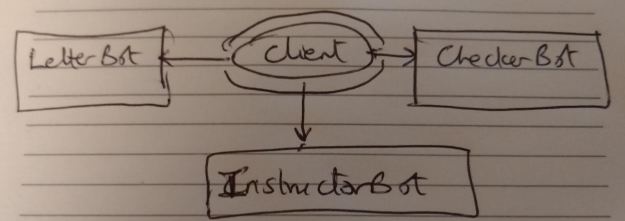


You could generalise things as follows:
1. The main class could be `MultiAgentProject`.
2. A single agent could be the `Coordinator`.
3. All other agents can respond with either:
   - a simple text response, e.g.: `A polar bear`
   - or an instruction to forward to response, e.g.: `Send to ArcticExplorer: A polar bear`
   - NOTE: This approach will allow for more nuanced interactions where some agents can direct their outputs straight to another.
4. Needs better failure handling and retry capabilities:
   - Maybe all agents can accept something like: `"Re-read your initial prompting, and try again."`
5. Needs a history object so that all history is accessible.
6. All complex stuff that just needs generic code can sit in the client package, e.g.:
   - Interactions with GitHub
   - Simple actions that Python can do
7. Input files can be uploaded to the workspace associated with the Assistants, so this might be appropriate.